=== Python ===
3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)] 

=== Package presence check ===
pandas: found
numpy: found
matplotlib: found
seaborn: found
statsmodels: found
sklearn: found
folium: found
branca: found
IPython: found
jupyterlab: found
ipykernel: found
=== Versions ===
pandas: 2.2.3
numpy: 2.2.4
matplotlib: 3.10.1
seaborn: 0.13.2
statsmodels: 0.14.5
scikit-learn: 1.6.1
folium: 0.20.0
branca: 0.8.1
IPython: 9.0.2
jupyterlab: 4.3.6
ipykernel: 6.29.5

=== OLS quick check ===
R^2: 1.0
Params: {'const': 49.870903660268596, 'Tot_Pop': 7.98897676956077e-05, 'Mean_Unempl': -0.3268188311096196, 'Pov_Ad_Tot': -1.499981928371521, 'Ad_Poor_MH_fourteen': 0.9090795932998788}

=== LASSO quick check ===
alpha: 4.602938399457008
coef (std-space): [8.229550891401447, -0.0, -4596.740980617514, 0.0]


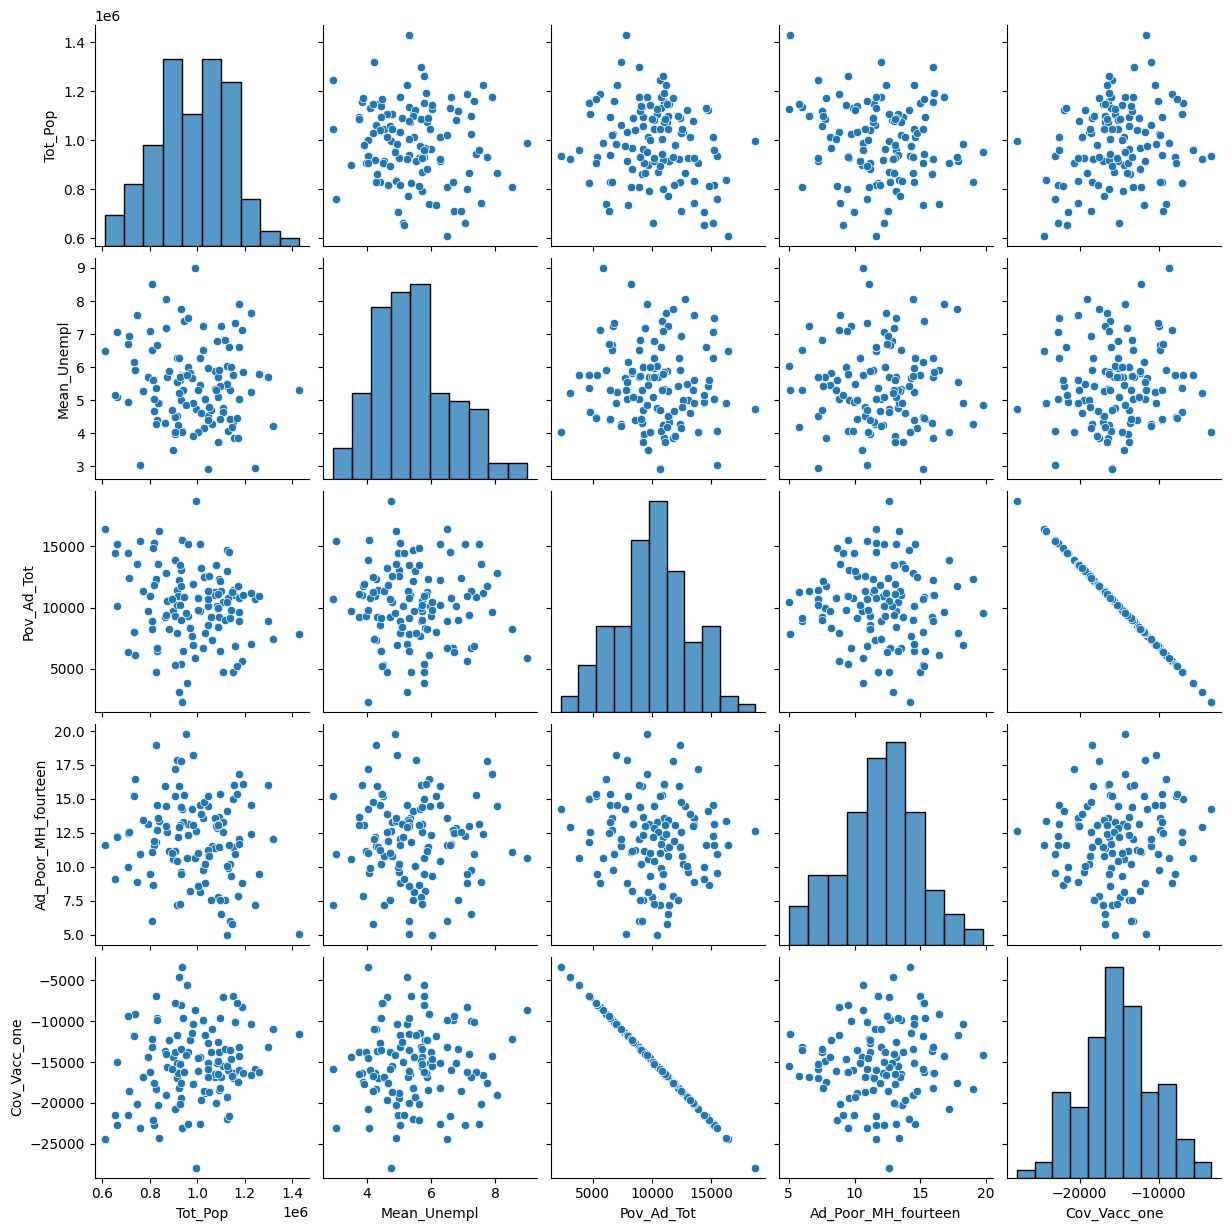

Saved: output/smoke_pairplot.png
Saved: output/smoke_map.html

✅ Smoke test completed successfully.


In [1]:
# === One-Cell Jupyter Smoke Test: env check + OLS/LASSO + plots ===
import sys, os, importlib, subprocess

print("=== Python ===")
print(sys.version, "\n")

# ---- package check & auto-install ----
required = {
    "pandas": "pandas",
    "numpy": "numpy",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "statsmodels": "statsmodels",
    "sklearn": "scikit-learn",
    "folium": "folium",
    "branca": "branca",
    "IPython": "ipython",
    "jupyterlab": "jupyterlab",
    "ipykernel": "ipykernel",
}

missing = []
print("=== Package presence check ===")
for mod, pipname in required.items():
    if importlib.util.find_spec(mod) is None:
        print(f"{mod}: MISSING → will install ({pipname})")
        missing.append(pipname)
    else:
        print(f"{mod}: found")

if missing:
    print("\nInstalling missing packages into current kernel...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
    print("\nRe-checking after install...\n")

# re-import and print versions (don’t crash if something still missing)
def safe_ver(modname, attr="__version__"):
    try:
        m = importlib.import_module(modname)
        return getattr(m, attr, "(no __version__)")
    except Exception as e:
        return f"MISSING ({e.__class__.__name__})"

print("=== Versions ===")
print("pandas:",       safe_ver("pandas"))
print("numpy:",        safe_ver("numpy"))
print("matplotlib:",   safe_ver("matplotlib"))
print("seaborn:",      safe_ver("seaborn"))
print("statsmodels:",  safe_ver("statsmodels"))
print("scikit-learn:", safe_ver("sklearn"))
print("folium:",       safe_ver("folium"))
print("branca:",       safe_ver("branca"))
print("IPython:",      safe_ver("IPython"))
print("jupyterlab:",   safe_ver("jupyterlab"))
print("ipykernel:",    safe_ver("ipykernel"))

# ---- smoke analysis: OLS + LASSO + plots ----
try:
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    from sklearn.linear_model import LassoCV
    from sklearn.preprocessing import StandardScaler
    import folium
    from branca.colormap import linear

    # ensure output directory
    os.makedirs("output", exist_ok=True)

    # tiny synthetic dataset
    rng = np.random.default_rng(42)
    n = 120
    X = pd.DataFrame({
        "Tot_Pop": rng.normal(1_000_000, 200_000, n),
        "Mean_Unempl": rng.normal(5.5, 1.2, n),
        "Pov_Ad_Tot": rng.normal(10_000, 3_000, n),
        "Ad_Poor_MH_fourteen": rng.normal(12, 3, n),
    })
    beta = np.array([8e-5, -0.3, -1.5, 0.9])
    y = (X.values @ beta) + rng.normal(0, 1.0, n) + 50.0
    y = pd.Series(y, name="Cov_Vacc_one")

    # OLS
    Xc = sm.add_constant(X, has_constant="add")
    ols = sm.OLS(y, Xc).fit()
    print("\n=== OLS quick check ===")
    print("R^2:", round(float(ols.rsquared), 4))
    print("Params:", {k: float(v) for k, v in ols.params.items()})

    # LASSO (standardized)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    lasso = LassoCV(cv=5, random_state=42).fit(Xs, y)
    print("\n=== LASSO quick check ===")
    print("alpha:", float(lasso.alpha_))
    print("coef (std-space):", [float(c) for c in lasso.coef_])

    # Pairplot
    sns.pairplot(pd.concat([X, y], axis=1), diag_kind="hist")
    plt.savefig("output/smoke_pairplot.png", dpi=120, bbox_inches="tight")
    plt.show()
    print("Saved: output/smoke_pairplot.png")

    # Folium map
    m = folium.Map(location=[37.8, -96], zoom_start=4, tiles="cartodbpositron")
    folium.Marker([38.5, -97.5], popup="Center Marker").add_to(m)
    colormap = linear.YlOrRd_09.scale(0, 100)
    colormap.caption = "Sample Color Scale"
    m.add_child(colormap)
    m.save("output/smoke_map.html")
    print("Saved: output/smoke_map.html")

    print("\n✅ Smoke test completed successfully.")

except Exception as e:
    print("\n❌ Smoke test failed:", repr(e))
    print("Tip: If packages were just installed, try: Kernel → Restart Kernel, then re-run this cell.")
